In [65]:
from os import listdir
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import librosa
import numpy as np
import IPython.display as ipd

In [121]:
def data_load(path):
    audio_path = []
    audio_emotion = []
    directory_path = listdir(path)

    for audio in directory_path:
        audio_path.append(path+audio)
        emotion = audio.split("_")

        if emotion[2] == "ANG":
            audio_emotion.append("angry")
        elif emotion[2] == "FEA":
            audio_emotion.append("fear")
        elif emotion[2] == "DIS":
            audio_emotion.append("disgust")
        elif emotion[2] == "HAP":
            audio_emotion.append("happy")
        elif emotion[2] == "NEU":
            audio_emotion.append("neutral")
        elif emotion[2] == "SAD":
            audio_emotion.append("sad")

    emotion_dataset = pd.DataFrame(audio_emotion, columns=['Emotions'])
    audio_path_dataset = pd.DataFrame(audio_path, columns=['Path'])
    dataset = pd.concat([audio_path_dataset, emotion_dataset], axis= 1)

    return dataset

In [122]:
dataset = data_load(path = "./dataset/")

In [33]:
dataset["Emotions"].value_counts()

angry      1271
disgust    1271
fear       1271
happy      1271
sad        1271
neutral    1087
Name: Emotions, dtype: int64

<AxesSubplot: title={'center': 'Emotion Count'}, xlabel='Emotions', ylabel='Count'>

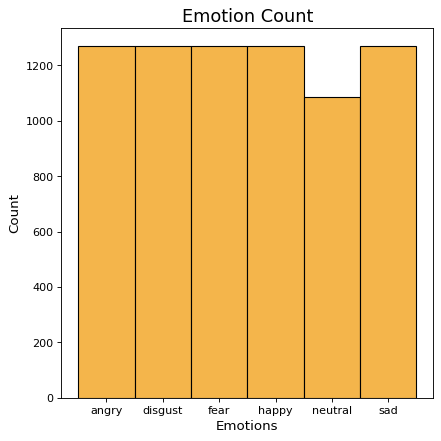

In [36]:
# counting audio categorized by emotions
plt.figure(figsize=(6,6), dpi=80)
plt.title("Emotion Count", size=16)
plt.xlabel('Emotions', size = 12)
plt.ylabel('Count', size = 12)
sns.histplot(dataset.Emotions, color='#F19C0E')

In [37]:
dataset

,Path,Emotions
0,./dataset/1001_DFA_ANG_XX.wav,angry
1,./dataset/1001_DFA_DIS_XX.wav,disgust
2,./dataset/1001_DFA_FEA_XX.wav,fear
3,./dataset/1001_DFA_HAP_XX.wav,happy
4,./dataset/1001_DFA_NEU_XX.wav,neutral
...,...,...
7437,./dataset/1091_WSI_DIS_XX.wav,disgust
7438,./dataset/1091_WSI_FEA_XX.wav,fear
7439,./dataset/1091_WSI_HAP_XX.wav,happy
7440,./dataset/1091_WSI_NEU_XX.wav,neutral


In [150]:

# load an individual sample audio file
# read the full 3 seconds of the file, cut off the first 0.5s of silence; native sample rate = 48k
# don't need to store the sample rate that librosa.load returns
file = "./dataset/1001_DFA_FEA_XX.wav"
music_array, sample_rate = librosa.load(file, sr=44100)

In [152]:
ipd.Audio(file)

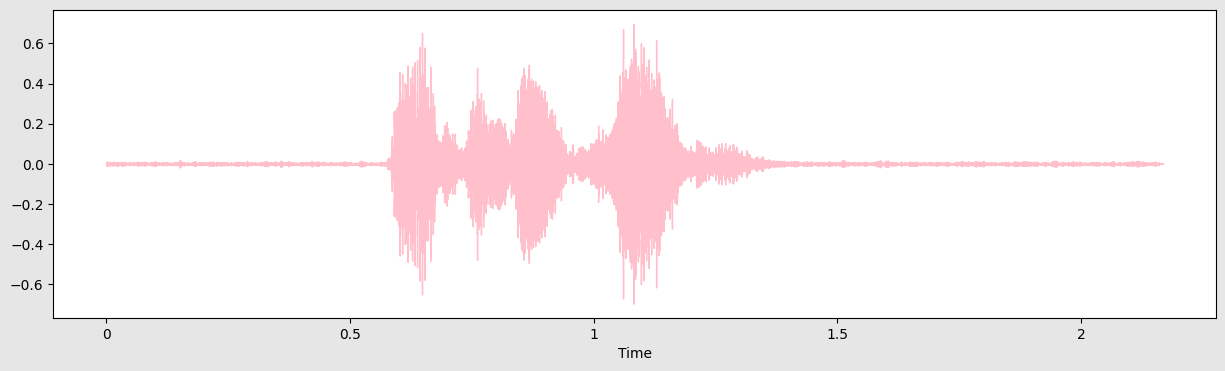

In [153]:
plt.figure(figsize=(15,4), facecolor=(.9,.9,.9))
librosa.display.waveshow(music_array, sr=44100, color="pink")

In [154]:
X = librosa.stft(music_array)
Xdb = librosa.amplitude_to_db(abs(X))

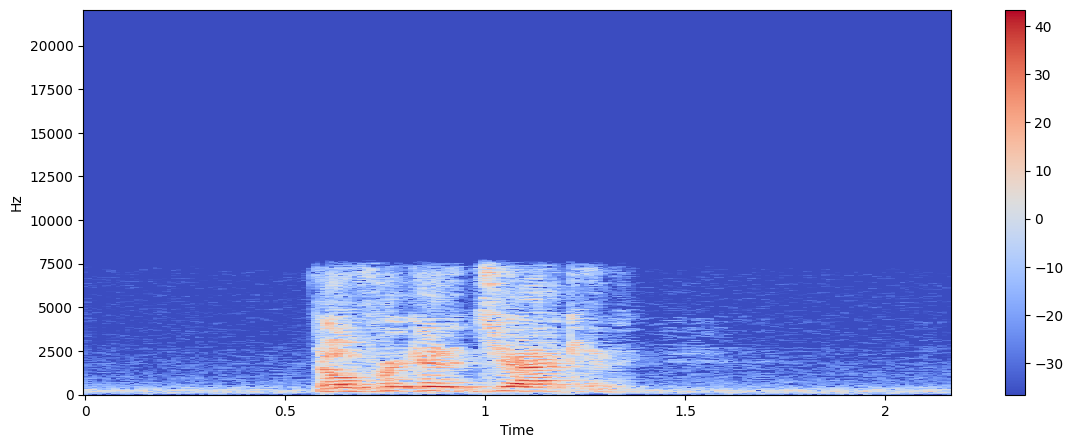

In [155]:
plt.figure(figsize=(14,5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis="time", y_axis="hz")
plt.colorbar()

In [156]:
print(music_array.shape, sample_rate)

(95645,) 44100


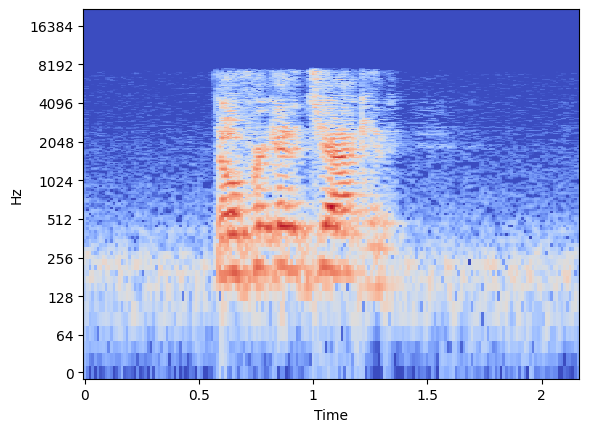

In [157]:
librosa.display.specshow(Xdb, sr=sample_rate, x_axis="time", y_axis="log")

In [160]:
X, Y = [], []

for path, emo, index in zip(dataset.Path, dataset.Emotions, range(len(dataset))):
    value, sample = librosa.load(path)
    # noise injection
    noise_amp = 0.035 * np.random.uniform() * np.amax(value)
    value = value + noise_amp * np.random.normal(size=value.shape[0])
    # mfcc
    mfcc = librosa.feature.mfcc(y=value, sr= sample, n_mfcc=13, n_fft=200, hop_length=512)
    mfcc = np.ravel(mfcc.T)
    # mel
    mel = librosa.feature.melspectrogram(y=value, sr=sample, hop_length = 256, n_fft = 512, n_mels=64)
    mel = librosa.power_to_db(mel ** 2)
    mel = np.ravel(mel).T
    result = np.array([])
    result = np.hstack((result, mfcc, mel))
    #print(result)
    result = np.array(result)
    X.append(result)
    Y.append(emo)

C:\Users\satri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


In [169]:
print(X[0])

[-692.08437338  -36.38775056    9.20260464 ...  -56.34224377  -56.34224377
  -56.34224377]


In [164]:
print(len(Y))

7442
